<div class="alert alert-block alert-info">
LINMA2415 - Project - Question 13

- Colson Adeline 19752000
    
- Lhernould Benoit 77102200 

- El Bared Mary Jo 48212000 
  
    
</div>

<div class="alert alert-block alert-info">
Load Data
</div>

In [1]:
using CSV, DataFrames, Dates, HiGHS, JuMP

In [2]:
df = CSV.read("data.csv", DataFrame)
D_t = df[!, "FR_load_forecast_entsoe_transparency"]

8760-element Vector{Float64}:
 56250.0
 54300.0
 53600.0
 50000.0
 47100.0
 45850.0
 45850.0
 46000.0
 46400.0
 46950.0
 49100.0
 51500.0
 54000.0
     ⋮
 66500.0
 66500.0
 64200.0
 61450.0
 60150.0
 62500.0
 65600.0
 65000.0
 62300.0
 59850.0
 59700.0
 63750.0

In [3]:
file_path = "capacity_pv.csv"
df = CSV.File(file_path; header=true) |> DataFrame
capacity_pv = Array(df)
    
file_path = "capacity_wind.csv"
df = CSV.File(file_path; header=true) |> DataFrame
capacity_wind = Array(df)

8760×1 Matrix{Float64}:
 0.12594
 0.123693
 0.124232
 0.13045
 0.140045
 0.136766
 0.129185
 0.135791
 0.152821
 0.14136
 0.126196
 0.137837
 0.165391
 ⋮
 0.254449
 0.250744
 0.250841
 0.28469
 0.31118
 0.31791
 0.320436
 0.322001
 0.312379
 0.272079
 0.214026
 0.166168

<div class="alert alert-block alert-info">
Constants and data
</div>

In [14]:
# Constants and Data
hours_per_year = 8760
lambda = 5000  
cost_of_debt = 0.04
cost_of_equity = 0.07
corporate_tax = 0.30
economic_life = 20
carbon_tax = 50 


capacity = Dict(
    "Coal" => 1,
    "CCGT" => 1,
    "OCGT" => 1,
    "Onshore Wind" => capacity_wind,
    "Offshore Wind" => capacity_wind,
    "PV" => capacity_pv
)

# Technologies data
technologies = Dict(
    "Coal" => (capex=2000*1000, om=0.03, debt_ratio=0.62, heat_rate=2.4, EA=175.2252157*1000, price =5, C=12, emissions=1.4),
    "CCGT" => (capex=950*1000, om=0.03, debt_ratio=0.56, heat_rate=1.62, EA=85.60445144*1000, price =30, C=48.6, emissions=0.5),
    "OCGT" => (capex=700*1000, om=0.03, debt_ratio=0.6, heat_rate=2.5, EA=61.91153839*1000, price =30, C=75, emissions=0.6),
    "Onshore Wind" => (capex=700*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=58.99797384*1000, price =0, C=0, emissions=0.0),
    "Offshore Wind" => (capex=1300*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=109.5676657*1000, price =0, C=0, emissions=0.0),
    "PV" => (capex=400*1000, om=0.03, debt_ratio=0.8, heat_rate=0, EA=32.04823387*1000, price =0, C=0, emissions=0.0)
)

#Battery data
F_b=6*1000
A_b=1.620627574*1000
eta=0.9
capex_b= 25000

25000

<div class="alert alert-block alert-info">
Question 13
</div>

In [15]:
T = 8760
model = Model(HiGHS.Optimizer)


@variable(model, k[g in keys(technologies)] >= 0)  # Installed capacity
@variable(model, p[g in keys(technologies), t=1:T] >= 0)  # Hourly production
@variable(model, d[t=1:T] >=0)
#For Battery
@variable(model, k_b>=0 ) 
@variable(model, e[1:T] >= 0)
@variable(model, p_in[1:T] >=0)
@variable(model, p_out[1:T] >=0)


@objective(model, Min, sum((technologies[g].om * technologies[g].capex + technologies[g].EA )*k[g] + sum(technologies[g].C*p[g,t]  for t in 1:T) for g in keys(technologies))+ (A_b + F_b)* k_b - sum( lambda * d[t] for t in 1:T)
+ carbon_tax * sum(technologies[g].emissions * sum(p[g, t] for t in 1:hours_per_year) for g in keys(technologies)))

@constraint(model, [ g in keys(technologies), t in 1:T], p[g,t] <= k[g])
@constraint(model, [t in 1:T], d[t]<=D_t[t])
@constraint(model, price[t in 1:T], -d[t] + p_out[t] - p_in[t]  + sum( p[g,t] for g in keys(technologies))==0)
@constraint(model, [t in 1:T], e[t]<= 4*k_b)
@constraint(model, [t in 1:T], p_in[t]<=k_b)
@constraint(model, [t in 1:T], p_out[t]<=k_b)
@constraint(model,  e[1]==0)
@constraint(model, [t in 2:T], e[t]== e[t-1] + 1*(sqrt(eta)* p_in[t-1] - 1/sqrt(eta) * p_out[t-1]))
for g in ["Coal", "CCGT", "OCGT"]
    @constraint(model, [t in 1:T], p[g, t] <= k[g])
end
for t in 1:T
    @constraint(model, p["Onshore Wind", t] <= capacity_wind[t]*k["Onshore Wind"])
    @constraint(model, p["Offshore Wind", t] <= capacity_wind[t]*k["Offshore Wind"])
    @constraint(model, p["PV", t] <= capacity_pv[t]*k["PV"])
end

optimize!(model)
# print("Variables value, p:",JuMP.value.(p))
print("Variables value, k:",value.(k))
print("Variables value, k_b:",value.(k_b))
# print("Variables value, d:",value.(d))
print("Objective value: ", objective_value(model))
print(keys(technologies))
                    
######################################################################################################################
println("\n")

println("\n")
println("Point I")
println("Optimal capacities (kW):")
total_production = 0
production_by_tech = Dict(g => 0.0 for g in keys(technologies))
for g in keys(technologies)
    cap = value(k[g])  # This ensures 'cap' remains a floating-point number
    println("$(g): $(cap) MW")
    for t in 1:hours_per_year
        production_by_tech[g] += value(p[g, t])  # Accumulate as floating-point values
        total_production += value(p[g, t])  # Keep total production as floating-point
    end
end

println("\n")

println("Point II")
println("Share of each technology in effective production:")
for g in keys(technologies)
    share = production_by_tech[g] / total_production
    println("$(g): $(share * 100) %")
end
println("\n")


println("Point III")
println("Total Production: $(total_production) MWh")
total_cost = capex_b*value(k_b)+sum((technologies[g].EA+technologies[g].capex)*value.(k[g])+sum((technologies[g].C)*value.(p[g,i]) for i in 1:hours_per_year)  for g in keys(technologies))
println("Total Investment and Production Cost: €$(total_cost)")
println("\n")

println("Point IV")
# CO2 Emissions data
emissions = Dict(
    "Coal" => 1.4,
    "CCGT" => 0.5,
    "OCGT" => 0.6,
    "Onshore Wind" => 0.0,
    "Offshore Wind" => 0.0,
    "PV" => 0.0
)

# Calculating CO2 emissionys
total_co2_emissions = sum(emissions[g] * production_by_tech[g] for g in keys(production_by_tech))
println("\nTotal CO2 Emissions: $(total_co2_emissions) tons")
println("\n")


println("Point V")
load_curtailment = sum(max(0, D_t[t] - sum(value(p[g, t]) for g in keys(technologies))) for t in 1:hours_per_year)
println("Total Load Curtailment: $(load_curtailment) MWh")
println("\n")


println("Point VI")
profit = Dict(g => 0.0 for g in keys(technologies))
prices = [-JuMP.dual(price[i]) for i in 1:hours_per_year]

for g in keys(technologies)
    profit[g] = -(technologies[g].EA + technologies[g].capex) * value(k[g]) - 
                 sum((technologies[g].C - prices[i]) * value(p[g, i]) for i in 1:hours_per_year)
end

for g in keys(technologies)
    println("Profit for technology $g: $(profit[g])")
end

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
144812 rows, 83500 cols, 360249 nonzeros
114425 rows, 83499 cols, 303581 nonzeros
Presolve : Reductions: rows 114425(-43255); columns 83499(-4108); elements 303581(-77750)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11961    -2.3484958374e+12 Pr: 12673(5.6774e+09); Du: 0(5.23722e-07) 5s
      17046    -2.3484946896e+12 Pr: 13338(4.97755e+10); Du: 0(3.79356e-07) 11s
      23085    -2.3381192622e+12 Pr: 36119(2.85362e+09); Du: 0(5.46172e-07) 16s
      46067    -2.3350540275e+12 Pr: 39474(1.99641e+09); Du: 0(2.4305e-07) 21s
      60266    -2.3338063701e+12 Pr: 0(0); Du: 0(2.29954e-07) 26s
      60266    -2.3337462950e+12 Pr: 0(0); Du: 0(1.26974e-08) 26s
Solving the original LP from the solution after postsolve
Model   status      : Optim

<div class="alert alert-block alert-info">
Question 14
</div>

In [5]:
using Plots

function optimize_capacity_emissions_with_battery(carbon_tax, A_b, F_b, eta, D_t, capacity_wind, capacity_pv)
    T = 8760
    model = Model(HiGHS.Optimizer)


    @variable(model, k[g in keys(technologies)] >= 0)  # Installed capacity
    @variable(model, p[g in keys(technologies), t=1:T] >= 0)  # Hourly production
    @variable(model, d[t=1:T] >=0)
    #For Battery
    @variable(model, k_b>=0 ) 
    @variable(model, e[1:T] >= 0)
    @variable(model, p_in[1:T] >=0)
    @variable(model, p_out[1:T] >=0)


    @objective(model, Min, sum((technologies[g].om * technologies[g].capex + technologies[g].EA )*k[g] + sum(technologies[g].C*p[g,t]  for t in 1:T) for g in keys(technologies))+ (A_b + F_b)* k_b - sum( lambda * d[t] for t in 1:T)
    + carbon_tax * sum(technologies[g].emissions * sum(p[g, t] for t in 1:hours_per_year) for g in keys(technologies)))

    @constraint(model, [ g in keys(technologies), t in 1:T], p[g,t] <= k[g])
    @constraint(model, [t in 1:T], d[t]<=D_t[t])
    @constraint(model, price[t in 1:T], -d[t] + p_out[t] - p_in[t]  + sum( p[g,t] for g in keys(technologies))==0)
    @constraint(model, [t in 1:T], e[t]<= 4*k_b)
    @constraint(model, [t in 1:T], p_in[t]<=k_b)
    @constraint(model, [t in 1:T], p_out[t]<=k_b)
    @constraint(model,  e[1]==0)
    @constraint(model, [t in 2:T], e[t]== e[t-1] + 1*(sqrt(eta)* p_in[t-1] - 1/sqrt(eta) * p_out[t-1]))
    for g in ["Coal", "CCGT", "OCGT"]
        @constraint(model, [t in 1:T], p[g, t] <= k[g])
    end
    for t in 1:T
        @constraint(model, p["Onshore Wind", t] <= capacity_wind[t]*k["Onshore Wind"])
        @constraint(model, p["Offshore Wind", t] <= capacity_wind[t]*k["Offshore Wind"])
        @constraint(model, p["PV", t] <= capacity_pv[t]*k["PV"])
    end

    optimize!(model)

    # Collect results
    capacities = Dict(g => value(k[g]) for g in keys(technologies))
    battery_capacity = value(k_b)
    total_emissions = sum(value(sum(p[g, t] for t in 1:T)) * technologies[g].emissions for g in keys(technologies))
    
    return (capacities, battery_capacity, total_emissions)
end


carbon_tax_levels = 0:20:500
capacities = []
emissions = []

for tax in carbon_tax_levels
    cap, batt_cap, em = optimize_capacity_emissions_with_battery(tax, A_b, F_b, eta, D_t, capacity_wind, capacity_pv)
    push!(capacities, cap)
    push!(emissions, em)
end


Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
144812 rows, 83500 cols, 360249 nonzeros
114425 rows, 83499 cols, 303581 nonzeros
Presolve : Reductions: rows 114425(-43255); columns 83499(-4108); elements 303581(-77750)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      12579    -2.3503103253e+12 Pr: 12738(9.25823e+09); Du: 0(5.23722e-07) 5s
      18509    -2.3503087817e+12 Pr: 13608(6.84852e+10); Du: 0(3.75177e-07) 11s
      21951    -2.3443972995e+12 Pr: 13657(3.32817e+10); Du: 0(3.75177e-07) 17s
      29215    -2.3426717600e+12 Pr: 21137(6.98205e+08); Du: 0(4.49966e-07) 23s
      34533    -2.3408958344e+12 Pr: 19924(1.33911e+09); Du: 0(3.03602e-07) 28s
      40266    -2.3403881224e+12 Pr: 42660(1.30832e+10); Du: 0(2.37212e-07) 34s
      45450    -2.3399851570e+12 Pr: 18828(9.64996e+08)

<div class="alert alert-block alert-info">
Save data to plot capacity bar with python code
</div>

In [8]:
using JSON

technologies = ["Coal", "CCGT", "OCGT", "Onshore Wind", "Offshore Wind", "PV"]  # Add more technologies if needed

capacity_data = Dict(tech => Float64[] for tech in technologies) 

for caps in capacities
    for tech in technologies
        push!(capacity_data[tech], get(caps, tech, 0.0))  # Get the capacity for each technology, defaulting to 0 if not present
    end
end

# Serialize the dictionary to a JSON string and write to a file
open("capacity_data.txt", "w") do file
    write(file, JSON.json(capacity_data))
end

2202

<div class="alert alert-block alert-info">
Plot CO2 emmissions vs carbon tax
</div>

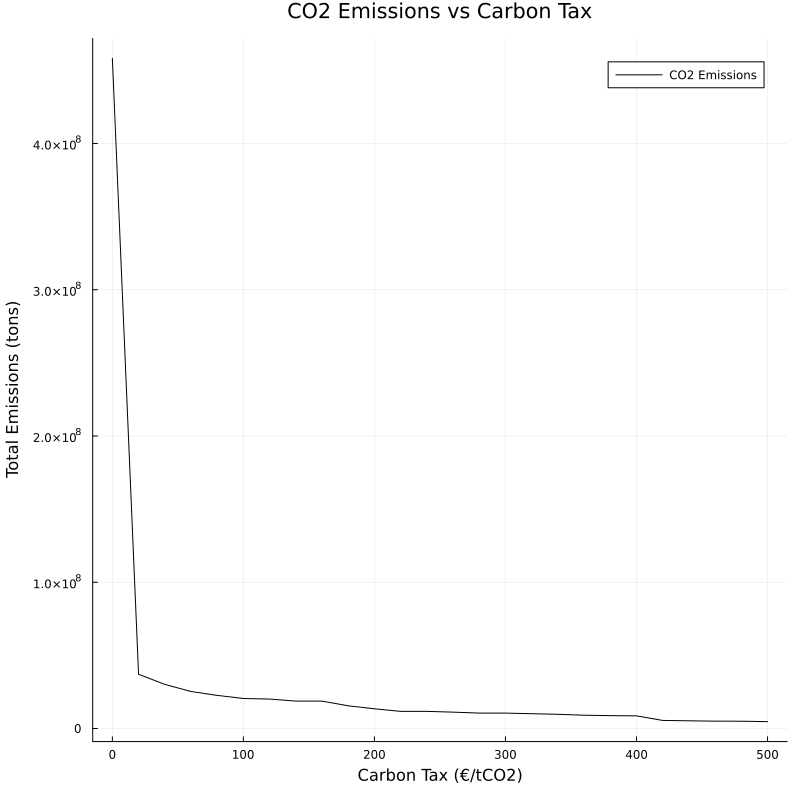

In [10]:
tax_labels = string.(carbon_tax_levels)

p2 = plot(carbon_tax_levels, emissions, label="CO2 Emissions", color=:black,
          title="CO2 Emissions vs Carbon Tax", xlabel="Carbon Tax (€/tCO2)", ylabel="Total Emissions (tons)",
          legend=:topright)

plot(p2, size=(800, 800))